# Ermitteln von stummen Schlaganfällen bei Patienten

<img src='a1.png' width="1200" height="800">

# Einleitung

Bei klinisch-stummen Schlaganfällen, handelt es sich um eine Form der Schlaganfälle, die frei von Sympomen verlaufen und somit meist nicht im Falle des Eintretens erkannt werden können. Die Folgen dieser Art des Schlaganfalls sind jedoch zu denen eines akuten Schlaganfalls mit dem Eintreten von Symptomen vergleichbar. Da sogenannte Hirninfarkte mit rund 85% aller Schlaganfälle die häufigste Variante sind, sind die am meisten auftretenden Folgen kognitive Störungen, wie Sprachverlust oder Gedächnisstörung. 

Mithilfe dieses Projekts soll es Ärzten möglich sein über die Eingabe von Patientendaten zu ermitteln, ob dieser Patient aus bekannten Fällen in seinem Leben schon einmal einen Schlaganfall hatte. Dies inkludiert auch stumme Schlaganfälle, von denen der Patient selbst noch nicht wusste.

Je nach Ergebnis des Modells kann der Arzt daraufhin Folgeuntersuchungen angehen, um die Folgen des Schlaganfalls zu verringern.

#### Ziele dieser Arbeit

Um das Thema der stummen Schlaganfälle bestmöglich mithilfe dieser Arbeit zu behandeln, werden folgende Ziele festgelegt:
* Durchführen einer **exploratory data analysis(EDA)** für den Datensatz unter Berücksichtigung des Anwedungsfalls
* **Erstellen** und **verbessern** eines, nach einem vorher festgelegten Gütekriterium, **optimalen Modells** zur Schlaganfallerkennung

# 1. Import der notwendigen Libraries

In diesem Abschnitt werden alle notwendigen Libraries hochgeladen und zur Verwendung bereitgestellt. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, classification_report
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Einlesen der Datei

In [ ]:
df = pd.read_csv ('/datasets/heathcare-dataset/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df.shape

(5110, 12)

In [ ]:
df_stroke = df.loc[df['stroke']== 1]
df_stroke.shape

(249, 12)

Wir merken uns, dass die Zielvariable unseres Datensatzes nicht gleichmäßig verteilt ist und lösen dieses Problem in der Modellvorbereitung

# 3. Vorbereitung der Daten

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


## 3.1 Umgehen mit fehlenden Werten

Beim Attribut 'bmi' sind lediglich 4909 Werte vorhanden, wobei bei allen anderen Attributen 5110 Werte vorhanden sind. Somit müssen in dieser Spalte fehlende Werte vorhanden sein:

In [ ]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

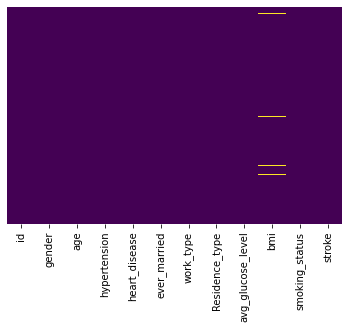

In [ ]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

## 3.2 Möglichkeiten mit den fehlenden Werten umzugehen

***1. Löschen aller Zeilen, die fehlende Werte beinhalten***
> Wie im vorhinein berechnet, hat der Datensatz insgesamt 5110 Zeilen, von denen 201 Zeilen fehlende Werte beinhalten. Da das Löschen der Zeilen in diesem Fall zu größeren Auswirkungen auf die Größe des Datensatzes und damit auch die Trainingsgröße des Modells hat, fällt diese Möglichkeit weg.
***2. Löschen der Spalte 'bmi'***
> Auch das Löschen der Spalte 'bmi' würde die Güte des Modells zu sehr beeinflussen, womit diese Möglichkeit nicht in Betracht gezogen werden kann.
***3. Ersetzen der fehlenden Werte durch den Durchschnittswert***
> Da die Variable 'bmi' abhängig von anderen Variablen ist, wäre eine Annäherung durch den Durchschnittswert nur sehr ungenau. **(Siehe Nr.5)**
***4. Fehlende Werte kategorischer Variablen mithilfe eines Algorithmus berechnen***
> Da es sich bei der Variable 'bmi', um eine kontinuierliche Variable handelt, ist es nicht möglich, einen Algorithmus für kategorische Variablen zu verwenden.
***5. Fehlende Werte kontinuierlicher Variablen mithilfe eines Algorithmus berechnen***
> Bei der Variable 'bmi' handelt es sich um eine kontinuierliche Variable, weshalb ein solcher Algorithmus verwendet werden sollte.

Damit dieser Algorithmus jedoch ein möglichst genaues Ergebnis erzielt, macht es Sinn, diesen nur auf die Spalten des Datensatzes anzuwenden, die mit der Spalte 'bmi' korrelieren. 
Um diese Spalten herauszufinden, ermitteln wir im Folgenden die Korrelationen für die Spalte 'bmi'. 

Dazu müssen jedoch zunächst die Zeilen mit fehlenden Werten vorübergehend aus dem Datensatz entfernt werden.

Möglich ist das mit der Funktion pandas dropna().

**(Vergl. Tamboli, 2001)**

In [ ]:
df_droped = df.dropna()

Überprüfen tun wir dies, indem wir die Anzahl der Zeilen und Spalten des Datensatzes ausgeben

In [ ]:
df_droped.shape

(4909, 12)

In [ ]:
df.corr()['bmi'].sort_values(ascending= False)

bmi                  1.000000
age                  0.333398
avg_glucose_level    0.175502
hypertension         0.167811
stroke               0.042374
heart_disease        0.041357
id                   0.003084
Name: bmi, dtype: float64

Damit der kNN-Algorithmus funktionieren kann, müssen die Werte der Variable 'gender' gegen Zahlenwerte ausgetauscht werden. 

## 3.3 Anwendung des K-Nearest-Neighbor Algorithmus

In [ ]:
imputer = KNNImputer(n_neighbors = 3)
knn_output = imputer.fit_transform(df[['bmi','age','avg_glucose_level','hypertension']])
print(knn_output.shape)
print(df[['bmi','age','avg_glucose_level','hypertension']].shape)

(5110, 4)
(5110, 4)


In [ ]:
bmi_values = []
for i in range(len(knn_output)):
    bmi_values.append(knn_output[i][0])

len(bmi_values)

5110

Nachdem wir die Werte für 'bmi' nun in einer Liste gespeichert haben, können wir diese in den ursprünglichen Datensatz einfügen.

In [ ]:
df_filled = df
df_filled['bmi']=bmi_values
df_filled.shape[0]
df_filled['bmi']

0       36.600000
1       30.866667
2       32.500000
3       34.400000
4       24.000000
          ...    
5105    26.066667
5106    40.000000
5107    30.600000
5108    25.600000
5109    26.200000
Name: bmi, Length: 5110, dtype: float64

In [ ]:
df_filled.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,26.066667,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0
5109,44679,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.200000,Unknown,0


In [ ]:
df_filled.shape

(5110, 12)

Der angepasste Datensatz hat den gelichen shape, wie der ursprüngliche. Somit wissen wir, dass keine Zeilen oder Spalten gelöscht wurden.

In [ ]:
df_filled.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

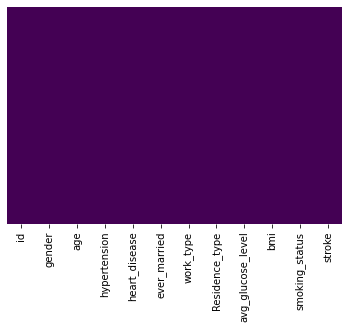

In [ ]:
sns.heatmap(df_filled.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

Die Daten wurden jetzt aufbereitet und können nun dazu genutzt werden, weitere Zusammenhänge in den Daten zu finden und zu visualisieren.

## 3.4 Kategorische Werte ersetzen

Unsere Features können in unterschiedliche Arten von Kategoriten unterteilt werden. So gibt es es folgende Kategorien:

-   Kategorische
    -   Nominal
        - Variablen die zwei oder mehr Kategorien haben, die aber keine festgelegte Reihenfolge haben.
            -       Work_type
            -       gender
    - Binäre 
        - Variablen die nur aus zwei Kategorien bestehen
            -       Ever-married
            -       Residence_type
    - Ordinal
        - Variablen die zwei oder mehr Kategorien haben, die aber in eine festgelegten Reihenfolge unterteilt werden können. 
            -       Smoking_status
- Numerische
    - Diskrete
        - Diskrete Variablen sind numerische Variablen, die zwischen zwei beliebigen Werten eine zählbare Anzahl von Werten aufweisen. Eine diskrete Variable ist immer numerisch.
            -       id
    - Kontinuierliche
        - Stetige Daten sind numerische Variablen, die zwischen zwei beliebigen Werten eine unendliche Anzahl von Werten aufweisen. 
            -       bmi
            -       avg_glucose_level

***

In diesem Zug können auch alle weiteren kategorischen Variablen ersetzt werden. Dafür lassen wir uns zunächst die möglichen Werte aller kategorischen Variablen anzeigen:

In [ ]:
cols = ['gender','hypertension','ever_married','work_type','Residence_type','smoking_status','stroke','heart_disease']
for i in range(len(cols)):
  print(cols[i],": ",df[cols[i]].unique().tolist())

gender :  ['Male', 'Female', 'Other']
hypertension :  [0, 1]
ever_married :  ['Yes', 'No']
work_type :  ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked']
Residence_type :  ['Urban', 'Rural']
smoking_status :  ['formerly smoked', 'never smoked', 'smokes', 'Unknown']
stroke :  [1, 0]
heart_disease :  [1, 0]


In [ ]:
# Löschen des Datensatzes, bei dem als Geschlecht "Other" angegeben wurde
# df.drop(df[df['gender'] == 'Other'].index, inplace=True)

Für alle Werte, die keine Zahlen sind, fügen wir numerische Werte ein.

In [ ]:
df.gender = df.gender.replace({'Male':0,'Female':1,'Other':2}).astype(np.uint8)
df.Residence_type = df.Residence_type.replace({'Rural':0,'Urban':1}).astype(np.uint8)
df.work_type = df.work_type.replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':3,'Never_worked':4}).astype(np.uint8)
df.smoking_status = df.smoking_status.replace({'never smoked':0,'smokes':1,'formerly smoked':2, 'Unknown':3}).astype(np.uint8)
df.ever_married = df.ever_married.replace({'No': 0, 'Yes': 1}).astype(np.uint8)

df.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,18234,1,80.0,1,0,1,0,1,83.75,26.066667,0,0
5106,44873,1,81.0,0,0,1,1,1,125.20,40.000000,0,0
5107,19723,1,35.0,0,0,1,1,0,82.99,30.600000,0,0
5108,37544,0,51.0,0,0,1,0,0,166.29,25.600000,2,0
5109,44679,1,44.0,0,0,1,2,1,85.28,26.200000,3,0


Nachdem die kategorischen Variablen nun gegen numerische Werte ersetzt wurden, kann im Folgenden der kNN-Algorithmus zur Annäherung der fehlenden Werte innerhalb der Spalte 'bmi' genutzt werden.

# 4. Datenanalyse

## Löschen der Spalte "id"

Zunächst löschen wir die Spalte "id", da Sie für die Korreletionsmatrix keine Rolle spielt und somit überflüssig wird.

In [ ]:
df_filled.drop(["id"],axis=1)
df_filled

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,1,0,1,228.69,36.600000,2,1
1,51676,1,61.0,0,0,1,1,0,202.21,30.866667,0,1
2,31112,0,80.0,0,1,1,0,0,105.92,32.500000,0,1
3,60182,1,49.0,0,0,1,0,1,171.23,34.400000,1,1
4,1665,1,79.0,1,0,1,1,0,174.12,24.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,1,80.0,1,0,1,0,1,83.75,26.066667,0,0
5106,44873,1,81.0,0,0,1,1,1,125.20,40.000000,0,0
5107,19723,1,35.0,0,0,1,1,0,82.99,30.600000,0,0
5108,37544,0,51.0,0,0,1,0,0,166.29,25.600000,2,0


## 4.1 Korrelationsmatrix

Dafür wird zunächst die Korrelationsmatrix erstellt.

<AxesSubplot:>

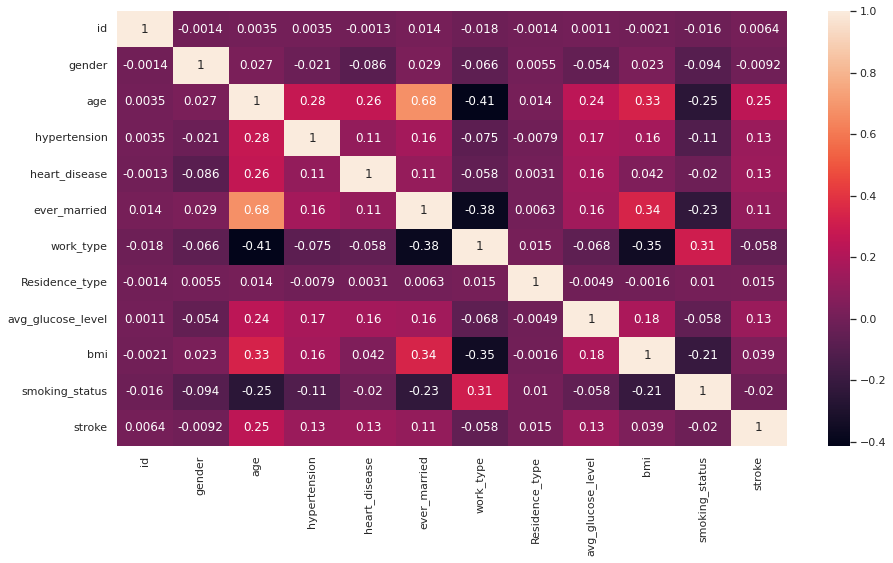

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df_filled.corr(), annot=True)

Wir verwenden die Korrelationsmatrix, um die Stärke und Richtung der Beziehung zwischen zwei Variablen zu bewerten. Ein hoher, positiver Korrelationswert bedeutet, dass die Variablen dasselbe Merkmal messen. Wenn die Items nicht hoch korreliert sind, dann messen die Items möglicherweise unterschiedliche Merkmale oder sind nicht klar definiert.

Betrachten wir die drei höchsten Werte, so besteht eine positive lineare Beziehung zwischen **ever_married und age**, **bmi und age**, sowie **smoking_status und work_type**. Die Pearson-Korrelationskoeffizienten für diese Paare sind:

> Ever_married und Age: **0,68**

> Bmi und Age: **0,34**

> Smoking_status und work_type: **0,31**

Für jede dieser linearen Beziehung visualisieren wir die Abhängigkeit und stellen die Wichtigkeit dieser Korrelationen im Hinblick auf die Wissenschaft dar.

## 4.2 Ever_married und Age:

### Visualisierung

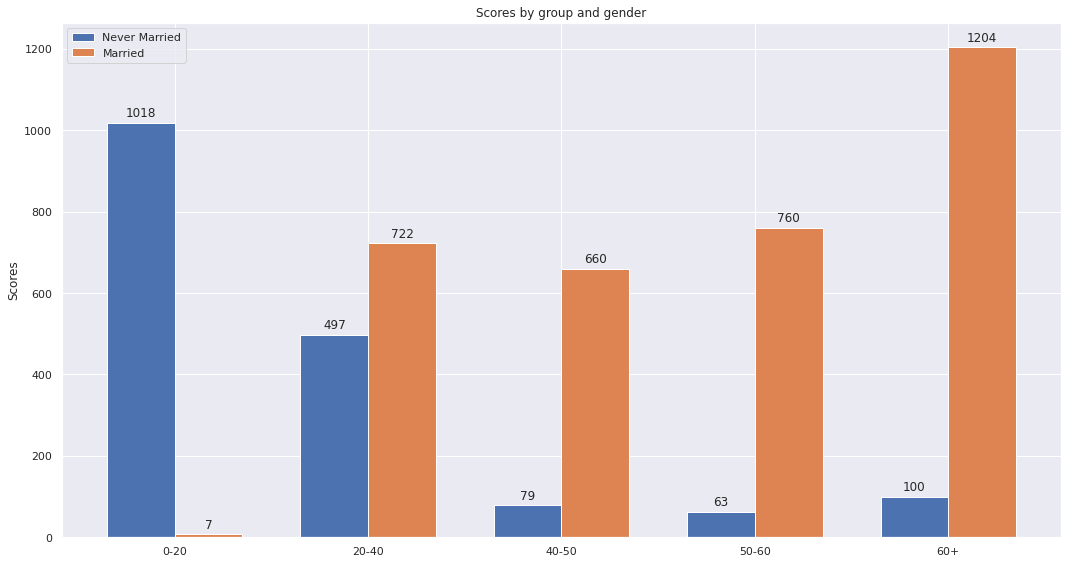

In [ ]:
df_20 = df_filled[df_filled['age']<=20]
df_40 = df_filled[(df_filled['age']>=21 ) & (df['age']<=40)]
df_50 = df_filled[(df_filled['age']>=41 ) & (df['age']<=50)]
df_60 = df_filled[(df_filled['age']>=51 ) & (df['age']<=60)]
df_old = df_filled[df_filled['age']>=61]

df_20_count = df_20['ever_married'].value_counts()
df_40_count = df_40['ever_married'].value_counts()
df_50_count = df_50['ever_married'].value_counts()
df_60_count = df_60['ever_married'].value_counts()
df_old_count = df_old['ever_married'].value_counts()

labels = ['0-20', '20-40', '40-50', '50-60', '60+']

never_married = [df_20_count[0], df_40_count[0], df_50_count[0], df_60_count[0], df_old_count[0]]
married = [df_20_count[1], df_40_count[1], df_50_count[1], df_60_count[1], df_old_count[1]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, never_married, width, label='Never Married')
rects2 = ax.bar(x + width/2, married, width, label='Married')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

### Löschen der Spalte "Ever-married"

Da die beiden Spalten "Ever-married" und "Age" sehr stark korrelieren, macht es Sinn eine der Spalten zu löschen. In unserem Fall macht es Sinn, die Spalte "Ever-married" zu löschen, da "Age" später in den nachfolgenden Schritten bei der Modellbildung eine Rolle spielt.

In [ ]:
df_filled.drop(['ever_married'],axis=1)


,id,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,0,1,228.69,36.600000,2,1
1,51676,1,61.0,0,0,1,0,202.21,30.866667,0,1
2,31112,0,80.0,0,1,0,0,105.92,32.500000,0,1
3,60182,1,49.0,0,0,0,1,171.23,34.400000,1,1
4,1665,1,79.0,1,0,1,0,174.12,24.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,1,80.0,1,0,0,1,83.75,26.066667,0,0
5106,44873,1,81.0,0,0,1,1,125.20,40.000000,0,0
5107,19723,1,35.0,0,0,1,0,82.99,30.600000,0,0
5108,37544,0,51.0,0,0,0,0,166.29,25.600000,2,0


## 4.3 BMI-Analyse

### Visualisierung

#### Abhängigkeit vom Glukosewert

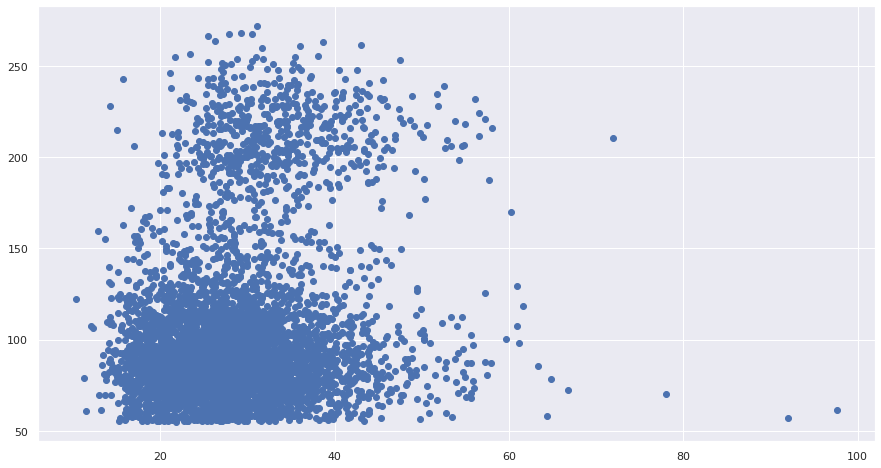

In [ ]:
plt.scatter(df_filled['bmi'], df_filled['avg_glucose_level'])
plt.show()

In [ ]:
df_male = df_filled.loc[df_filled['gender'] == 0]
df_female = df_filled.loc[df_filled['gender'] == 1]

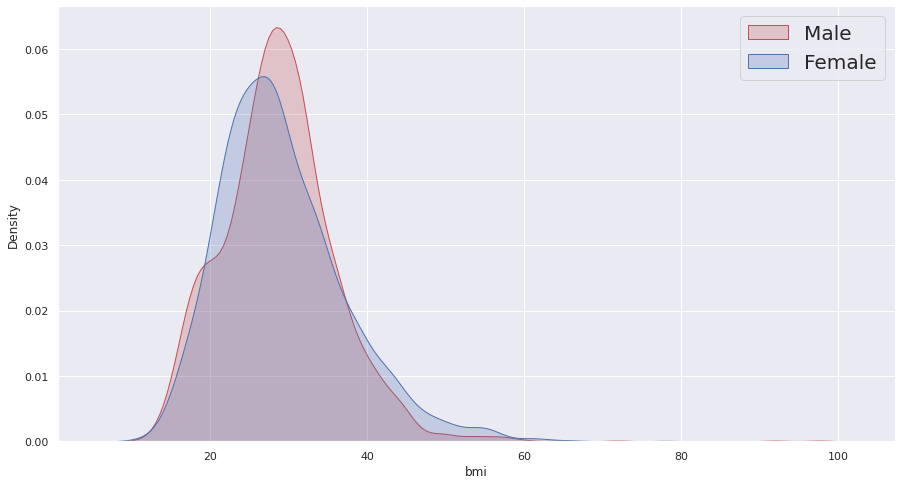

In [ ]:
sns.set(style="darkgrid")

fig = sns.kdeplot(df_male['bmi'], shade=True, color="r", label="Male")
fig = sns.kdeplot(df_female['bmi'], shade=True, color="b", label="Female")
plt.legend(prop={'size': 20})
plt.show()

#### Abhängigkeit vom Alter

In [ ]:
df_20 = df_filled[df_filled['age'] <= 20]
df_40 = df_filled[(df_filled['age']>=21 ) & (df_filled['age']<=40)]
df_50 = df_filled[(df_filled['age']>=41 ) & (df_filled['age']<=50)]
df_60 = df_filled[(df_filled['age']>=51 ) & (df_filled['age']<=60)]
df_70 = df_filled[df_filled['age'] >= 61]

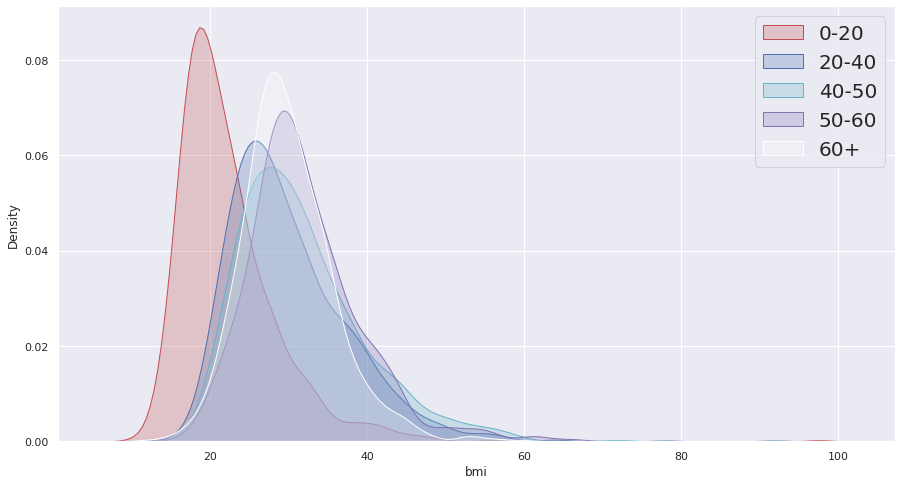

In [ ]:
sns.set(style="darkgrid")

fig = sns.kdeplot(df_20['bmi'], shade=True, color="r", label="0-20")
fig = sns.kdeplot(df_40['bmi'], shade=True, color="b", label="20-40")
fig = sns.kdeplot(df_50['bmi'], shade=True, color="c", label="40-50")
fig = sns.kdeplot(df_60['bmi'], shade=True, color="m", label="50-60")
fig = sns.kdeplot(df_70['bmi'], shade=True, color="w", label="60+")
#fig(figsize=(8, 6))

plt.legend(prop={'size': 20})
plt.show()

Basierend auf den Graphen können wir keine eindeutige Aussage über die Korrelation zwischen dem Alter und dem BMI machen. Wir sehen lediglich dass jüngere Personen im Alter von 0 - 20 Jahren einen niedrigen BMI Index vorweisen.
Es reicht jedoch nicht aus um eines der beiden Variablen auszublenden, da die Korrelation zu niedrig ist.

## 4.4 Smoking_status und Work_type

### Visualisierung

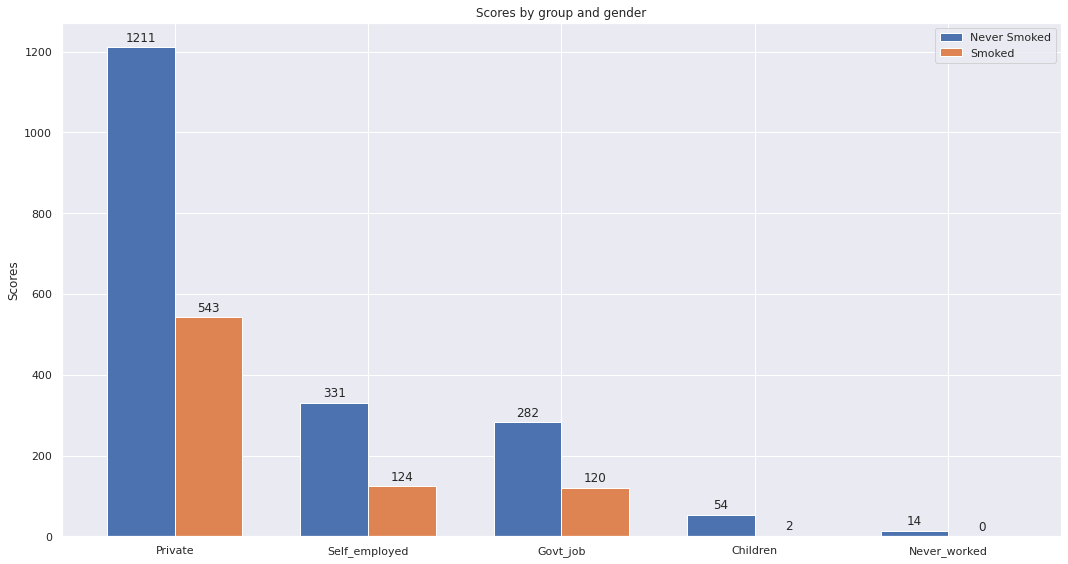

In [ ]:

#df.smoking_status = df.smoking_status.replace({'never smoked':0,'smokes':1,'formerly smoked':2, 'Unknown':3}
#df.work_type = df.work_type.replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':3,'Never_worked':4}).astype(np.uint8)


df_private = df_filled[df_filled['work_type']==0]
df_self_employed = df_filled[(df_filled['work_type'] == 1)]
df_govt_job = df_filled[(df_filled['work_type'] == 2)]
df_children = df_filled[(df_filled['work_type'] == 3)]
df_never_worked = df_filled[df_filled['work_type'] == 4]

df_private_count = df_private['smoking_status'].value_counts(sort=False)
df_self_employed_count = df_self_employed['smoking_status'].value_counts(sort=False)
df_govt_count = df_govt_job['smoking_status'].value_counts(sort=False)
df_children_count = df_children['smoking_status'].value_counts(sort=False)
df_never_worked_count = df_never_worked['smoking_status'].value_counts(sort=False)

labels = ['Private', 'Self_employed', 'Govt_job', 'Children', 'Never_worked']

no_smoke = [df_private_count[0], df_self_employed_count[0], df_govt_count[0], df_children_count[0], df_never_worked_count[0]]
smokes = [df_private_count[1], df_self_employed_count[1], df_govt_count[1], df_children_count[1], 0]



x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, no_smoke, width, label='Never Smoked')
rects2 = ax.bar(x + width/2, smokes, width, label='Smoked')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

Es können keine eindeutigen Aussagen getroffen werden, da wir keinen Zusammenhang zwischen den einzelnen Berufsgruppen und dem Raucheranteil sehen können.

## 4.5 Korrelation zwischen Stroke und Features

Vorangegangen sind die Analysen zweier stark korrelierenden Features. In diesem Abschnitt schauen wir uns die Korrelationen einzelner Features im Verhältnis zu der Zielvariable **stroke** an.

***

Wenn wir uns die Zielvariable genauer ansehen, so könne man meinen, dass einige Faktoren sich mehr oder weniger auf das Ergebnis auswirken.
Folgende Thesen haben wir uns aufgeschrieben, von denen man ausgehen könnte, das Sie stimmen.

- Geschlecht
    - Durch das Geschlecht könne man davon ausgehen, dass Aufgrund der biologischen Eigenschaften die Wahrscheinlichkeit für einen Schlaganfall bei beiden Geschlechtern unterschiedlich ausfällt.
-   Alter
    - Das Alter könnte eine entscheidende Rolle im Bezug auf die Zielvariable spielen, da mit zunehmenden Alter, die Wahrscheinlichkeit für ein Schlaganfall höher ausfällt.
-   Herzkrankheit
    - Durch eine chronische Herzkrankheit ist im Allgemeinen das Risiko eines Schlaganfalles erhöht, da Herzkrankheiten als Hauptursache dafür gelten.

### Gender und Stroke

In [ ]:
jmale= df_filled.loc[df_filled['gender'] == 0]
s=jmale['stroke'].value_counts()

jfemale= df_filled.loc[df_filled['gender'] == 1]
t=jfemale['stroke'].value_counts()

In [ ]:
print(jmale.stroke.value_counts())
jfemale.stroke.value_counts()

0    2007
1     108
Name: stroke, dtype: int64


0    2853
1     141
Name: stroke, dtype: int64

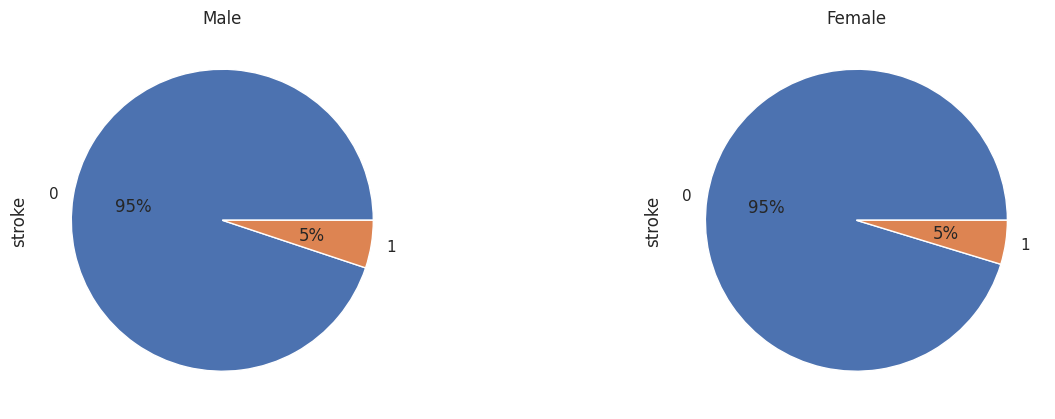

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=100, figsize=(15, 5))

# Darstellen der Ungleichverteilung innerhalb der Zielvariable
jmale.stroke.value_counts().plot(kind='pie',title='Male', ax=axes[0], autopct='%1.0f%%')
jfemale.stroke.value_counts().plot(kind='pie', title='Female', ax=axes[1], autopct='%1.0f%%');


Basierend auf den beiden Kreisdiagrammen oben lässt sich die anfangs gestellte Hypothese nicht bestätigen. Sowohl Männer als Frauen zeigen ein identisches Muster. Beide Geschlechter haben eine Wahrscheinlichekit von 5% an einem Schlaganfall zu leiden.


### Age und Stroke

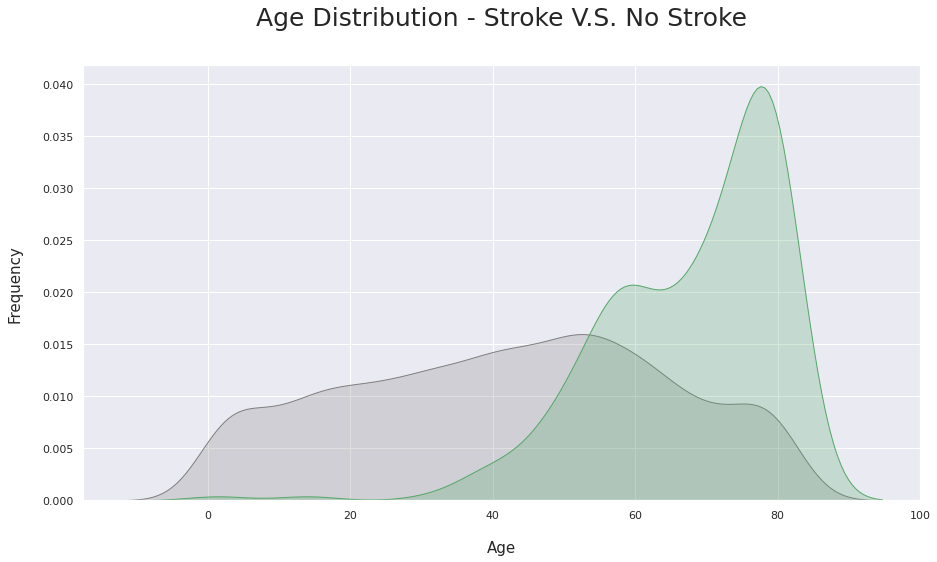

In [ ]:
# Kernel Density Plot
fig = plt.figure(figsize=(15,8),)
ax=sns.kdeplot(df_filled.loc[(df_filled['stroke'] == 0),'age'] , color='gray',shade=True,label='no Stroke')
ax=sns.kdeplot(df_filled.loc[(df_filled['stroke'] == 1),'age'] , color='g',shade=True, label='Stroke')
plt.title('Age Distribution - Stroke V.S. No Stroke', fontsize = 25, pad = 40)
plt.xlabel("Age", fontsize = 15, labelpad = 20)
plt.ylabel('Frequency', fontsize = 15, labelpad= 20);

Unsere Hypothese, die wir anfangs aufgestellt haben, lässt sich bestätigen. Wie man aus der Grafik entnehmen kann, sind die meisten Betroffenen älter als 55. Damit lässt sich ein lineares Verhältnis zwischen dem Alter und der Wahrscheinlichkeit für einen Schlaganfall festhalten.

### Heart_diseases und Stroke

In [ ]:
df_selected = df_filled[["heart_disease","stroke"]]
df_selected

,heart_disease,stroke
0,1,1
1,0,1
2,1,1
3,0,1
4,0,1
...,...,...
5105,0,0
5106,0,0
5107,0,0
5108,0,0


In [ ]:
DeepnoteChart(df_selected, """{"data":{"name":"placeholder"},"mark":{"type":"bar","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"nominal","field":"heart_disease","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"nominal","field":"stroke","scale":{"type":"linear","zero":true}},"color":{"sort":null,"type":"quantitative","field":"COUNT(*)","scale":{"type":"linear","zero":false},"aggregate":"count"}}}""")

alt.Chart(...)

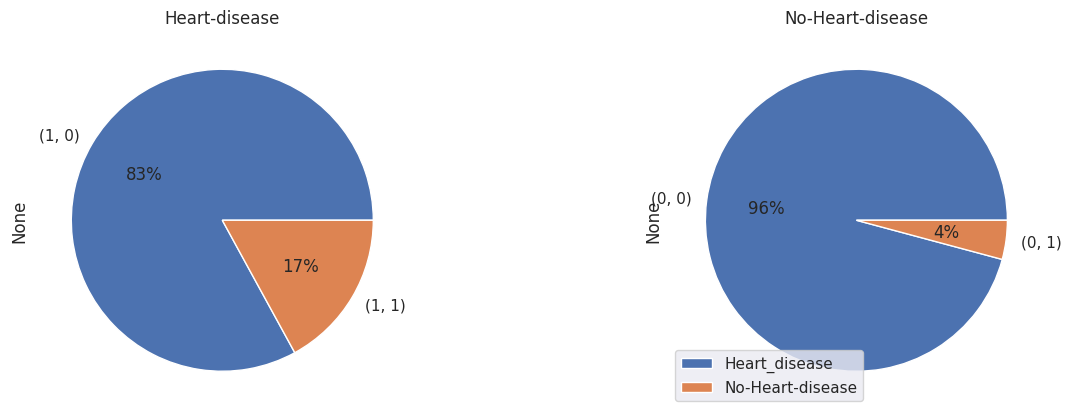

In [ ]:
only_heartdisease = df_selected[df_selected['heart_disease'] == 1]
only_heartdisease1 = df_selected[df_selected['heart_disease'] == 0]

only_heartdisease
#only_heartdisease.info()
only_handstroke = only_heartdisease[only_heartdisease['stroke']==1]
#only_handstroke
#only_handstroke.value_counts()
df_filled.heart_disease.value_counts()

fig, axes = plt.subplots(nrows=1, ncols=2, dpi=100, figsize=(15, 5))

# Darstellen der Ungleichverteilung innerhalb der Zielvariable
only_heartdisease.value_counts().plot(kind='pie',title='Heart-disease', ax=axes[0], autopct='%1.0f%%')
only_heartdisease1.value_counts().plot(kind='pie', title='No-Heart-disease', ax=axes[1], autopct='%1.0f%%');


labels = ['Heart_disease', 'No-Heart-disease']

plt.legend(labels,loc=3)
plt.show()



Zu sehen sind zwei Kreisdiagramme, die beide die Wahrscheinlichkeiten eines Schlaganfalles bei Vorhanden und Nicht-Vorhanden einer Herzkrankheit darstellen.

***

Aus den beiden Grafiken können wir entnehmen, dass die Wahrscheinlichkeit ein Schlaganfall zu erleiden, bei Vorhanden einer Herzkrankheit viel höher ausfällt.
Somit lässt sich unsere Hypothese, die wir anfangs aufgestellt haben, bestätigen.


#  5. Modellvorbereitung

## 5.1 Analyse der Zielvariable

0    4861
1     249
Name: stroke, dtype: int64


<BarContainer object of 2 artists>

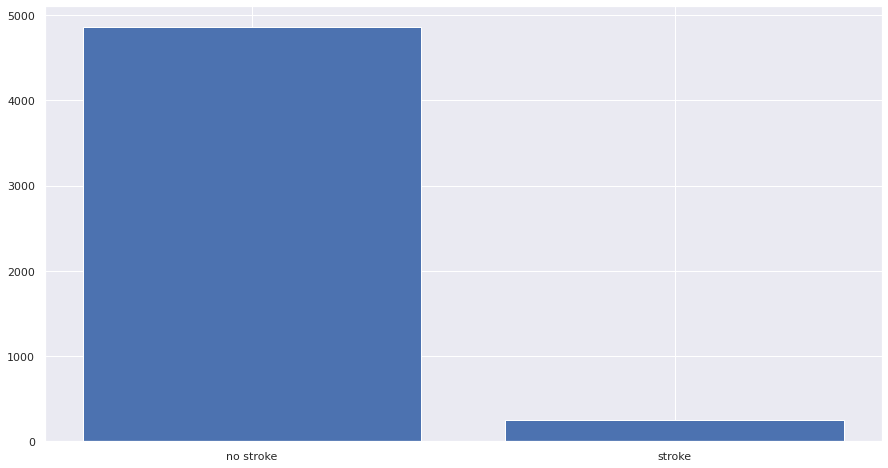

In [ ]:
print(df_filled['stroke'].value_counts(sort=False))

plt.bar(('no stroke', 'stroke'), [df_filled['stroke'].value_counts(sort=False)[0], df_filled['stroke'].value_counts(sort=False)[1]])

Es fällt auf, dass die Elemente der Zielvariable 'y' nicht gleichmäßig verteilt sind. 4861 der 5110 Patienten hatten in Ihrem Leben noch keinen Schlaganfall, wobei nur 249 schon einmal einen Schlaganfall erlitten.

### 5.1.1 Ungleichverteilung der Zielvariable

**Warum ist eine Ungleichverteilung der Zielvariable ein Problem?**

Die meisten Modelle gehen davon aus, dass die Zielvariable, auf die sie trainiert werden, gleichverteilt ist. Ist das nicht der Fall, ist das Modell sehr voreingenommen gegenüber neuen Daten, da im Trainingsdatensatz in rund **95%** der Fällen (in dem gegebenen Datensatz) die Zielvariable den selben Wert angenommen hat(vgl. Spelmen, S.1). Für das Modell ist es so sehr schwierig, die relevanten Informationen aus der selten vertretenen Klasse innerhalb der Zielvariable zu nutzen, um so gute Ergebnisse zu erzielen (vgl. Spelmen, S.1 f.).

Aus diesen Gründen ist es im Folgenden notwendig dit dieser Ungleichverteilung umzugehen:

Im Folgenden werden dazu zwei Möglichkeiten auf Datenebene betrachtet (vgl. Spelmen, 2018, S.2):

<img src='Resampling.png' width="1200" height="800">
Link zum <a href="https://github.com/ufoym/imbalanced-dataset-sampler">Bild</a>

***1. Upsampling / over-sampling***
> Mithilfe des Upsamplings wird die Minderheit innerhalb der Zielvariable künstlich vergrößert. Dadurch würden ansatt von 249, 4861 Einträge auftreten, bei denen der Patient in seinem Leben schonmal einen Schlaganfall hatte. Das Problem an dieser Methode ist es, dass das Testen dieses Datensatz kein sinnvolles Ergebnis ergibt. Da bestimmte Einträge durch diese Methode vermehrt im Datensatz auftreten, kennt das Modell im Testdurchlauf viele der Einträge schon durch den Trainingsdurchlauf. Das Ergebnis des Modells wird dadurch sehr genau, was jedoch nicht representativ ist, da die übergebenen Daten dem Modell bekannt sind.
***2. Downsampling / under-sampling***
> Beim Downsampling wird der Datensatz so stark verkleinert, dass beide Klassen der Zielvariable gleichverteilt autreten. Im betrachteten Datensatz treten so nach dem Downsampling nur noch 249 Einträge auf, bei denen der Patient in seinem Leben noch keinen Schlaganfall hatte.

In unserem Beispiel ist die Möglichkeit des Downsampling vorzuziehen, da dadurch das Testen des Modells representativere Ergebnisse erzielt und so die Modelle besser verglichen werden können.

### 5.1.2 Downsampling

Downsamping der Einträge von Patienten, die noch nie einen Schlaganfall hatten:

In [ ]:
stroke_downsample = resample(df_filled[df_filled['stroke'] == 0],
             replace=True,
             n_samples=len(df_filled[df_filled['stroke'] == 1]),
             random_state=42)

print(stroke_downsample.shape)

(249, 12)


Nach dem durchgeführten Downsampling hat der Datensatz nun eine Länge von 498 Einträgen


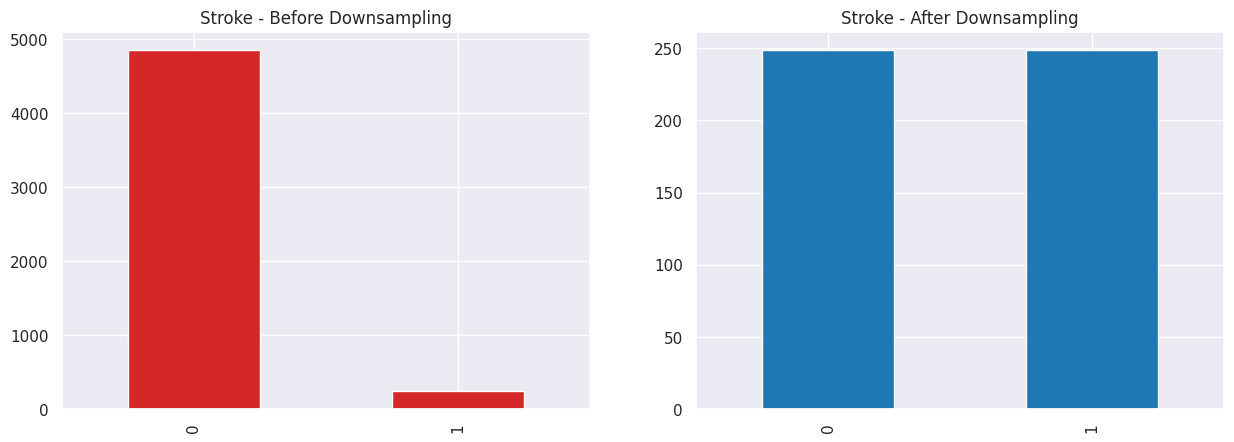

In [ ]:
df_downsampled = pd.concat([stroke_downsample, df_filled[df_filled['stroke'] == 1]])
print(f'Nach dem durchgeführten Downsampling hat der Datensatz nun eine Länge von {len(df_downsampled.stroke)} Einträgen')
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=100, figsize=(15, 5))

# Darstellen der Ungleichverteilung innerhalb der Zielvariable
df_filled.stroke.value_counts().plot(kind='bar', color='tab:red', title='Stroke - Before Downsampling', ax=axes[0])
df_downsampled.stroke.value_counts().plot(kind='bar', color='tab:blue', title='Stroke - After Downsampling', ax=axes[1]);

Die Zielvariable ist nun gleichmäßig verteilt. Nun kann der Datensatz für das Modell vorbereitet werden.

## 5.2 Labels von Datensatz trennen

In [ ]:
X = df_downsampled.drop(columns = ['stroke','id'])
print(X)
y = df_downsampled['stroke']

      gender    age  hypertension  heart_disease  ever_married  work_type  \
1109       1  27.00             0              0             0          0   
4021       0   0.16             0              0             0          3   
3341       1  59.00             0              0             1          0   
715        1  28.00             1              0             0          0   
4675       0   8.00             0              0             0          3   
...      ...    ...           ...            ...           ...        ...   
244        0  57.00             0              0             1          0   
245        1  14.00             0              0             0          3   
246        1  75.00             0              0             1          1   
247        0  71.00             1              0             1          1   
248        1  78.00             0              0             1          0   

      Residence_type  avg_glucose_level   bmi  smoking_status  
1109       

## 5.3 Aufteilen des Datensatzes in Trainings- und Testdaten

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((398, 10), (398,), (100, 10), (100,))

## 5.4 Feature Scaling

Bevor anfangen werden kann, Modelle auf dem Datensatz laufen zu lassen, muss der Datensatz zunächst dafür angepasst werden. Dazu werden zunächst die Daten angezeigt:

In [ ]:
headers = X.columns
X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
95,1,78.0,0,0,1,0,0,235.63,32.3,0
117,0,74.0,0,0,1,0,1,72.96,31.3,1
2703,1,26.0,0,0,0,0,1,100.31,38.6,0
1053,1,53.0,0,0,1,1,1,63.78,25.9,0
4742,0,48.0,0,0,1,0,0,98.24,34.6,0


In den Daten ist deutlich zu sehen, dass manche Variablen (**Features**) sehr hohe Werte annehmen und andere Variablen (binäre/kategorische) nur sehr geringe Werte. Damit die Modelle, die später auf diesen Daten trainiert werden, dadurch nicht irritiert werden und möglicherweise Variablen wie **age**, **avg_glucose_lvl** oder **bmi** stärker gewichten als andere, müssen wir dies anpassen.

Dazu können Methoden des Feature Scaling genutzt werden. Im gegeben Fall wird das sklearn-Modul **StandardScaler** verwendet. Die Dokumentation zu diesem Modul ist <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">hier</a> zu finden.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
pd.DataFrame(X_train, columns=headers).head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,0.931957,1.070574,-0.449908,-0.383372,0.544442,-0.712354,-1.111735,2.239445,0.446928,-1.114132
1,-1.073010,0.892904,-0.449908,-0.383372,0.544442,-0.712354,0.899495,-0.796511,0.299691,-0.280627
2,0.931957,-1.239138,-0.449908,-0.383372,-1.836743,-0.712354,0.899495,-0.286070,1.374524,-1.114132
3,0.931957,-0.039864,-0.449908,-0.383372,0.544442,0.303836,0.899495,-0.967840,-0.495391,-1.114132
4,-1.073010,-0.261952,-0.449908,-0.383372,0.544442,-0.712354,-1.111735,-0.324703,0.785574,-1.114132


Durch diese Anpassungen können nun Modelle auf diesen Daten angewendet werden.

# 6. Modellanwendung

## 6.1 Gütekriterium ermitteln

Damit wir die trainierten Modelle korrekt für unseren Anwendungsfall bewerten können, muss zunächst ein passendes Gütekriterium gewählt werden. Um dieses zu ermitteln, spielen die verschiedenen Formen der Klassifikation eine Rolle. Die folgenden Punkte bilden die Möglichkeiten ab, die ein Modell bei der Vorhersage eines Elements hat:

- **True Positive (TP)**
> Das Element wurde korrekt positiv gelabelt.
- **False Positive (FP) = Fehler 1. Art**
> Das Element wurde positiv gelabelt, obwohl es in Wahrheit negativ ist.
- **True Negative (TN)**
> Das Element wurde korrekt negativ gelabelt.
- **False Negative (FN) = Fehler 2. Art**
> Das Element wurde negativ gelabelt, obwohl es in Wahrheit positiv sind.

Da das Modell, welches wir trainieren, dazu genutzt werden soll, stumme Schlaganfälle zu erkennen, ist ein **False Negative-Wert** und damit ein **Fehler 2. Art** im Training des Modells priorisiert zu verhinden.
Beim Fehler 1. Art würde das Modells auf einen vorhergegangenen Schlaganfall hinweisen, welcher jedoch nie passiert ist. Dies hätte in der Folge lediglich höhere Kosten für Untersuchungen zur Folge. 

Ergibt sich jedoch ein 0-Label aus dem Modell, welches falsch prognostiziert wurde, wird der Patient nicht weiter behandelt, was die Folgen des Schlaganfalls verstärken würde. Dieser Fehler 2. Art muss verhindert werden, weshalb ein Gütekriterium gewählt werden muss, welches maximal wird, wenn der Fehler 2. Art minimal wird.

Dazu sind im Folgenden einige Gütekriterien dargestellt:

**Accuracy:**

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

**Recall:**

> $$Recall = \frac{TP}{TP + FN}$$

**Precision:**

$$Precision = \frac{TP}{TP + FP}$$

**F1-Score:**

$$F1 = 2 * \frac{Recall*Precision}{Recall+Precision}$$

**(vgl. Hossin, 2015, S.4)**

Das Gütekriterium, bei dem der Fehler 2. Art und damit die FalseNegativ-Werte die größte Auswirkung hat, ist der **Recall**. Aus diesem Grund wird zum jetzigen Zeitpunkt dieses Gütekriterium als Zielwert präferiert, um das bestmögliche Modell zu ermitteln.

Eine weitere Möglichkeit, die Güte eines Modells zu testen, ist das Erstellen einer **ROC-Kurve**. 
Mithilfe dieser wird die Falsch-Positiv-Rate (FPR) über der Richtig-Positiv-Rate (RPR) angezeigt (siehe Abb. 6.1) **(vgl. Weiß, 2018, S.704)**.

<figure>
<img align = "center" src="ROC-Kurve.png" alt="Drawing" style="width: 250px;"/>
<figcaption align = "center"><b>Abb. 6.1 - ROC-Kurve</b></figcaption>
</figure>

Die Fläche unterhalb der Kurve wird **AUC**(Area under Curve) genannt und wird immer dann 1, wenn alle Positv-vorhergesagten Elemente wirklich positiv sind. 0 ist sie dann, wenn alle Positiv-vorhergesagten Elemente falsch predicted wurden **(vgl. Weiß, 2018, S.704)**.

Im vorliegenden Anwedungsfall ist die ROC-Kurve, bzw. der AUC-Wert kein sinnvolles Maß, um die Güte des Modells zu testen. Hierbei werden die Positiv-vorhergesagten Elemente berücksichtigt, die für die Betrachtung, wie vorhin gezeigt, jedoch keine priorisierte Bedeutung haben. Daher wird weiterhin das Gütekriterium **Recall** zur Ermittlung der Güte verwendet

## 6.2 Klassifikationsmodelle trainieren


Im folgenden trainieren wir verschiedene Klassifikationsmodelle und lassen uns für jedes dieser den Recall-Wert auf den Testdaten ausgeben. Anschließend vergleichen wir genannte Modelle.

### 6.2.1 Random Forest Classifier

Der **Random Forest Classifier** ist eine Weiterentwicklung der **Entscheidungsbäume**, um die mit ihnen einhergehenden Nachteile zu reduzieren. 

Entscheidungsbäume sind eine Möglichkeit des **Teile-und-herrsche-Verfahrens**, um bestimmte Datensätze in Klassen einteilen zu können **(vgl. Myles, S.1)**. An jedem Knoten eines solchen Baumes wird von dem Algorithmus eine Entscheidung darüber getroffen, welche Abzweigung dieses Knotens gewählt wird. Dies wird solange durchgeführt, bis der Algorithmus an einem Blatt des Entscheidungsbaums angelangt ist, welches einer Klasse der Zielvariable zugeordnet ist. Diese Klasse wird dem eingegebenen Datensatz zugewiesen **(vgl. Myles, S.1)**.

Der hauptsächliche Nachteil dieser Entscheidungsbäume, ist das Verzerrung-Varianz-Dilemma (vgl. Peargin, S.3).

Der Random Forest Classifier ist ein "Ensemble Modell", was bedeutet, dass voneinander unabhängige Modelle trainiert und die Ergebnisse anschließend zusammengefasst werden **(vgl. Peargin, S.3)**. Im Falle des Random Forest Classifier sind dies die Entscheidungsbäume als Modelle.
Um die Unabhängigkeit der Modelle zu gewährleisten, wird jedes dieser mit einer individuellen Kombination an Eingabeparametern trainiert. Zusätzlich wird mithilfe des Bootstraping-Verfahrens nur eine Stichprobe des Trainingssatzes für jedes Modell angewendet **(vgl. Peargin, S.3)**.

Zum Zusammenfassen der Ergebnisse, wird die Vorhersage übernommen, die von den meisten Entscheidungsbäumen für einen Datensatz ausgegeben wurde **(vgl. Peargin, S.3)**. 

Für den gegebenen Anwedungfall wurde dieses Modell gewählt, da es mit binären, kontinuierlichen und kategorischen Werte gut umgehen kann **(vgl. Paergin, S.2)**.  


In [ ]:
clf_rfc = RandomForestClassifier()
clf_rfc.fit(X_train,y_train)
y_pred_rfc = clf_rfc.predict(X_test)
rfc_rec = recall_score(y_test, y_pred_rfc)

print('Testing-set Recall score is:', rfc_rec)

Testing-set Recall score is: 0.9387755102040817


### 6.2.2 Support Vector Machines

**Support Vector Machines** können sowohl als Klassifikations-, als auch als Regressionsmodelle trainiert werden **(Vgl. Chen, S.9)**. Im Folgenden wird auf die binäre Klassifikation mithilfe dieses Modells eingegangen, da diese für das Anwendungsbeispiel die relevante ist.

Um die Klassifikation des Datensatzes zu ermöglichen, wird eine **Hyperebene** in den Parameterraum gelegt, um diesen in die verschiedenen Klassen einzuteilen. Das Ziel ist es, diese Hyperebene möglichst in die Mitte der beiden Klassen unserer Zielvariable zu legen. In Abb. 6.2.21 sind im zweidimensionalen Raum mögliche Hyperebenen zu sehen.

<figure>
<img align = "center" src="SVM.png" alt="Drawing" style="width: 250px;"/>
<figcaption align = "center"><b>Abb. 6.2.21 - Mögliche Hyperebenen</b></figcaption>
</figure>

Um von diesen Hyperebenen jedoch die zu finden, die die verschiedenen Klassen bestmöglich voneinander trennt, werden **Support Vektoren** genutzt. Diese beziehen sich auf die Trainingsprobenpunkte, "die der Hyperebene am nächsten liegen" **(Chen, S.9)** Zwischen diesen Support Vektoren für beide Klassen soll der Abstand (**"Margin"**) maximiert werden, sodass die Hyperebene optimal zwischen den Randpunkte der Klassen liegt (siehe Abb. 6.2.22).

<figure>
<img src="SVM_Margin.png" alt="Drawing" style="width: 250px;"/>
<figcaption align = "center"><b>Abb. 6.2.22 - Optimale Hyperebene mit den dazugehörigen Support Vectoren</b></figcaption>
</figure>

Um jedoch auch Klassifikationsprobleme zu lösen, bei denen ein linearer Ansatz keine zufriedenstellenden Ergebnisse erzielt, wird in diesen Fällen der "Kernel-Trick"angewandt **(vgl. Chen, S.9)**:

**Kernel-Trick**

In den meisten Anwendungsbereichen ist es nicht möglich den Trainingsdatensatz, wie eben beschrieben linear zu trennen und so zu klassifizieren **(vgl. Hofmann, S.10)**. Dieses Problem kann mithilfe eines gesetzten Kernels gelöst werden. Dieser erweitert die Anzahl der Dimensionen so, dass eine Klassifizierung mithilfe einer Hyperebene möglich ist **(vgl. Chen, S.9)**. 

Das Klassifizierungsproblem in Abb. 6.2.23 lässt sich ohne diese Erweiterung nicht linear in Klassen unterteilen. Erst durch die Umwandlung in eine höhere Dimension ist es möglich eine Ebene zu definieren, die dies ermöglicht.

<figure>
<img src="SVM_Kernel.png" alt="Drawing" style="width: 500px;"/>
<figcaption align = "center"><b>Abb. 6.2.23 - Anwendung des Kernel Tricks auf ein Klassifizierungsproblem</b></figcaption>
</figure>

Zunächst wird das Support Vector Machine Modell ohne jegliche Übergabe von Eingabeparametern trainiert und getestet:

In [ ]:
clf_svm = SVC()
clf_svm.fit(X_train,y_train)
y_pred_svm = clf_svm.predict(X_test)
svm_rec = recall_score(y_test,y_pred_svm)
print("Support Vector Machines Model Recall score is:", svm_rec)

Support Vector Machines Model Recall score is: 0.8979591836734694


## 6.3 Modellvergleich vor dem Hyperparametertuning

Das für unser definiertes Gütekriterium beste Model ist "Random Forest" mit einem Recall von: 0.9387755102040817


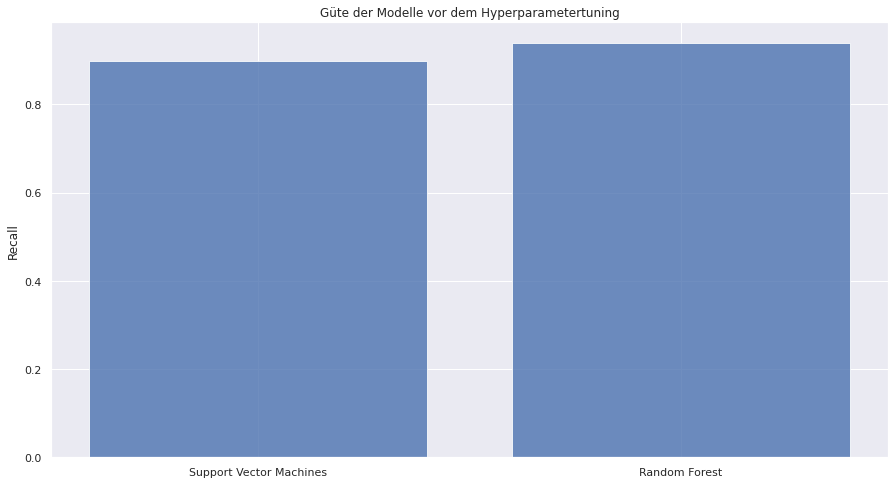

In [ ]:
rec_mod = {'Random Forest':rfc_rec, 'Support Vector Machines':svm_rec}
sort_rec = dict(sorted(rec_mod.items(), key=lambda x:x[1]))
print(f'Das für unser definiertes Gütekriterium beste Model ist "{list(sort_rec)[-1]}" mit einem Recall von: {sort_rec[list(sort_rec)[-1]]}')
y_pos = np.arange(len(sort_rec.keys()))

plt.bar(y_pos, sort_rec.values(), align='center', alpha=0.8)
plt.xticks(y_pos, sort_rec.keys())
plt.ylabel('Recall')
plt.title('Güte der Modelle vor dem Hyperparametertuning')

plt.show()

## 6.4 Hyperparametertuning

Um die gewählten Klassifikationsmodelle auf den im Projekt gegebenen Anwendungsfall zu trainieren, werden sogenannte Hyperparameter genutzt **(vgl. Siedel, 2021, S.51)**. Zur Wahl dieser Hyperparameter kann eine **Gittersuche** angewandt werden. Mit Hilfe dieser, werden alle Kombinationen von "Hyperparametern mit jeweils festgelegtem Suchintervall und festgelegter Suchschrittweite getestet" **(Siedel, 2021, S.52)**. Die Dimensionen dieses Gitters entsprechen dabei der Anzahl der vorhandenen Parameter. 
Nach erfolgreicher Durchführung der Gittersuche, wird die Kombination mit dem besten Resultat für die Modellbildung übernommen **(vgl. Siedel, 2021, S52)**.

Die Wahl dieser Hyperparameter ist je nach angewandtem Modell verschieden.
Für die in diesem Projekt gewählten Modelle werden folgende Parameter gemäß dem Anwendungsfall angepasst:

**1. Random Forest Classifier**

- **max_depth:** Welche Länge dürfen die verwendeten Entscheidungsbäume maximal haben?
- **max_features:** Wie viele Variablen (Features) dürfen pro Entscheidungsbaum maximal genutzt werden?
- **n_estimators:** Wie viele verschiedene Entscheidungsbäume werden trainiert?

**2. Support Verctor Machines**

- **C:** Soll stärker darauf geachtet werden, den Abstand zwischen den Support Vektoren (Margin) zu vergrößern (kleines C) oder sollen falsche Klassifikationen möglichst stark vermieden werden, auch wenn dadurch der Abstand steigt (großes C)?
- **Gamma:** Welchen Einfluss haben einzelne Beispiele im Trainingsdatensatz?
- **Kernel:** Mithilfe welcher Funktion wird der Paramterraum so umgewandelt, dass das Klassifizierungsproblem linear lösbar ist?

Zur Umsetzung dieser Gittersuche wird im folgenden das sklearn-Modul **GridSearchCV** verwendet. Die Dokumentation zu diesem Modul ist <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">hier</a> zu finden.

### 6.4.1 Random Forest Classifier Tuning - GridSearch

In [ ]:
param_grid_rfc = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'n_estimators': [100, 200, 300, 1000]
}

grid_rfc = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_rfc, cv= 5, scoring = 'recall')
grid_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3],
                         'n_estimators': [100, 200, 300, 1000]},
             scoring='recall')

In [ ]:
print(f'Folgende Parameter geben für die Support Vector Machines die besten Ergebnisse: {grid_rfc.best_params_}')

Folgende Parameter geben für die Support Vector Machines die besten Ergebnisse: {'max_depth': 80, 'max_features': 2, 'n_estimators': 1000}


Recall vor dem Hyperparametertuning: 0.9387755102040817
Recall nach dem Hyperparametertuning: 0.9183673469387755


<AxesSubplot:>

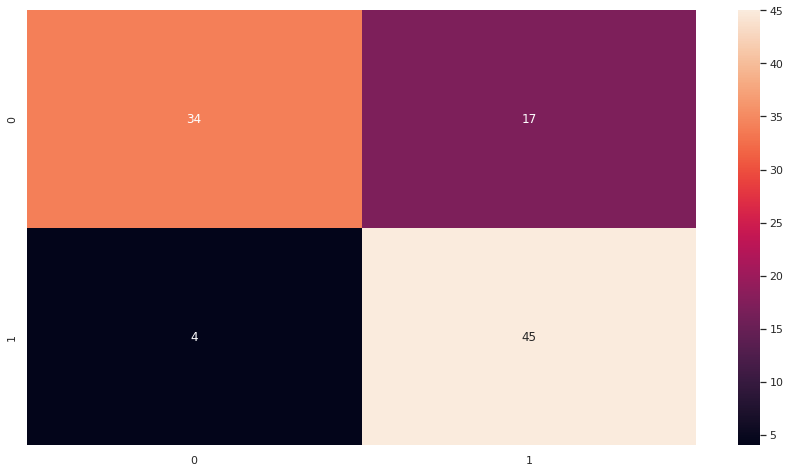

In [ ]:
grid_predictions_rfc = grid_rfc.predict(X_test)
rfc_rec_hyp = recall_score(y_test,grid_predictions_rfc)

print(f'Recall vor dem Hyperparametertuning: {rfc_rec}')
print(f'Recall nach dem Hyperparametertuning: {rfc_rec_hyp}')

cm = confusion_matrix(y_test, grid_predictions_rfc)
sns.heatmap(cm, annot = True, fmt="d")

### 6.4.2 Support Vector Machines Tuning - GridSearch

In [ ]:
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly', 'sigmoid']}
 
grid_svm = GridSearchCV(SVC(), param_grid=param_grid_svm, scoring='recall', verbose=3)
 
grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=1.000 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=1.000 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=1.000 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=1.000 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=1.000 total time=   0.0s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.675 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.675 total time=   0.0s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.625 total time=   0.0s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.625 total time=   0.0s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.550 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.825 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=1, kernel=sigmoid

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='recall', verbose=3)

In [ ]:
print(f'Folgende Parameter geben für die Support Vector Machines die besten Ergebnisse: {grid_svm.best_params_}')

Folgende Parameter geben für die Support Vector Machines die besten Ergebnisse: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


Recall vor dem Hyperparametertuning: 0.8979591836734694
Recall nach dem Hyperparametertuning: 1.0


<AxesSubplot:>

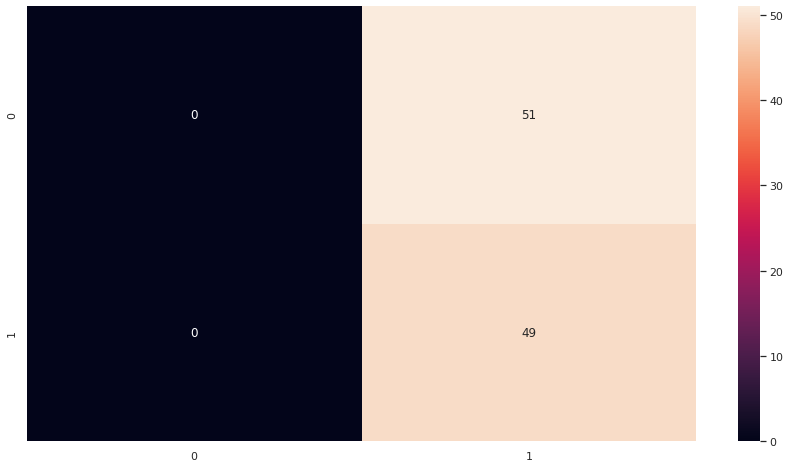

In [ ]:
grid_predictions_svm = grid_svm.predict(X_test)
svm_rec_hyp = recall_score(y_test,grid_predictions_svm)

print(f'Recall vor dem Hyperparametertuning: {svm_rec}')
print(f'Recall nach dem Hyperparametertuning: {svm_rec_hyp}')

cm = confusion_matrix(y_test, grid_predictions_svm)
sns.heatmap(cm, annot = True, fmt="d")

## 6.5 Modellvergleich nach dem Hyperparametertuning

Das für unser definiertes Gütekriterium beste Model nach dem Hyperparametertuning ist "Support Vector Machines" mit einem Recall von: 0.9183673469387755


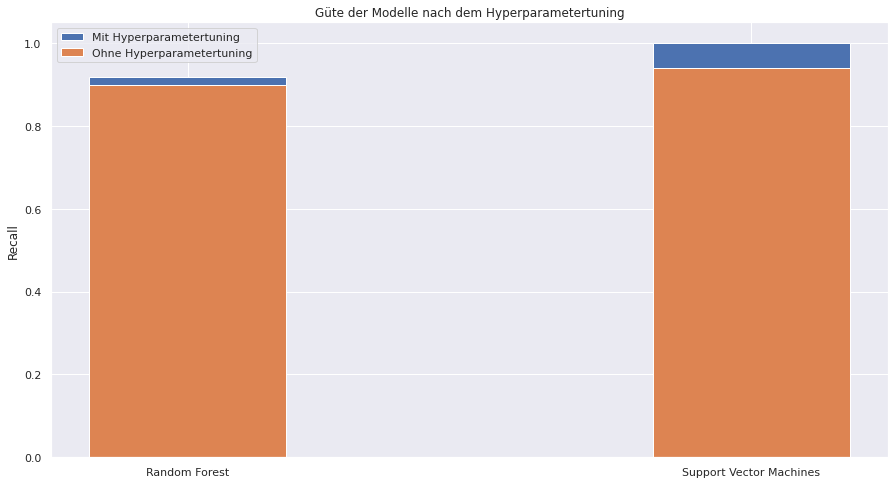

In [ ]:
rec_mod_hyp = {'Random Forest':rfc_rec_hyp, 'Support Vector Machines':svm_rec_hyp}
sort_rec_hyp = dict(sorted(rec_mod_hyp.items(), key=lambda x:x[1]))
print(f'Das für unser definiertes Gütekriterium beste Model nach dem Hyperparametertuning ist "{list(sort_rec_hyp)[-1]}" mit einem Recall von: {sort_rec_hyp[list(sort_rec)[-1]]}')

width = 0.35   

fig, ax = plt.subplots()

ax.bar(sort_rec_hyp.keys(), sort_rec_hyp.values(), width, label='Mit Hyperparametertuning')
ax.bar(sort_rec_hyp.keys(), sort_rec.values(), width, label='Ohne Hyperparametertuning')

ax.set_ylabel('Recall')
ax.set_title('Güte der Modelle nach dem Hyperparametertuning')
ax.legend()

plt.show()

# 7. Fazit

Ziel dieses Projekts war es, für unseren spezifischen Anwendungsfall ein bestmögliches Modell zu entwickeln.

Die Güte des Modells reicht nicht aus, um dieses als alleiniges 

# Literaturverzeichnis

**Literaturquellen:**

C. Müller, Andreas (Dpunkt.Verlag GmbH) (2017), Einführung in Machine Learning mit Python

**Bildquellen:**

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7315d564-c8d7-4ad9-a8db-a1aa41a30373' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>